# 집값 예측 경진대회

## 패키지 import 및 데이터 전처리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [208]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/test.csv')

In [182]:
df.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


`-` id는 필요없으니 제거

In [209]:
df.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

`-` 결측치는 없다

`-` 분석의 편의를 위해 컬럼명을 바꾸겠다

In [210]:
## 공백과 슬래쉬를 _로 대체 1을 숫자가 아닌 다른 문자로 바꿈 

df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'Fir') for column in df.columns])), inplace = True) 
test.rename(columns = dict(zip(test.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'Fir') for column in test.columns])), inplace = True) 

`-` 범주형 변수는 Exter Qual(외관 재료 품질;4개), Kitchen Qual(부엌 품질; 4개), Bsmt Qual(지하실 높이;5개)이다

`-` 총 5개의 등급이 존재하는데 Poor 등급은 Bsmt Qual에 1개 존재한다(나머지는 0개)

`-` 아예 poor등급이 존재하지 않는걸 수 도 있고 poor등급이 존재하는데 poor등급에 해당하는 건물이 존재하지 않는걸 수 도 있다

`-` 편의상 후자라고 생각하자(사실 후자가 맞다; 아님말고)

`-` 이들은 순서형 변수이므로 라벨 인코딩을 해주자

`-` 좋은 등급이 큰 값을 가지도록 하기위해 라벨인코딩을 정의해주자

In [185]:
def label_encoding(data):
    grade_label = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] ## 0~4점
    
    for grade, label in enumerate(grade_label):
        if data == label:
            return grade

In [211]:
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].apply(lambda x: label_encoding(x))

In [212]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

In [187]:
df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
0,10,2392,4,3,968,4,2392,2392,4,2,2003,2003,2003,386250
1,7,1352,3,2,466,3,1352,1352,4,2,2006,2007,2006,194000
2,5,900,2,1,288,2,864,900,2,1,1967,1967,1967,123000
3,5,1174,2,2,576,3,680,680,2,1,1900,2006,2000,135000
4,7,1958,3,3,936,3,1026,1026,3,2,2005,2005,2005,250000


`-` 라벨 인코딩이 잘 되었다

### 로그 변환 및 이상점 제거

`-` 앞서 EDA에서 집값(target)이 오른쪽으로 꼬리가 긴 분포임을 확인했다

`-` 정규분포로 맞춰주기 위해 로그변환을 하자

In [36]:
import scipy.stats as stats

<AxesSubplot:>

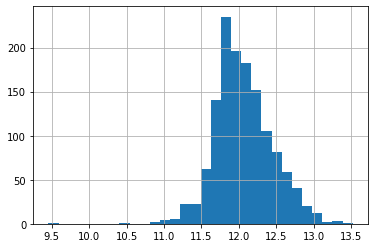

In [10]:
np.log(df['target']).hist(bins = 30)

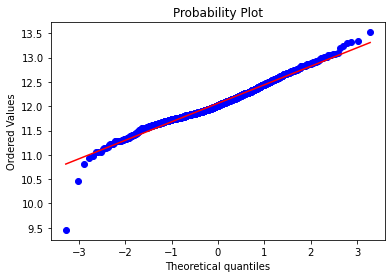

In [11]:
_ = stats.probplot(np.log(df['target']), plot = plt)

`-` 로그 변환을 했지만 정규분포를 따르지 않는것처럼 보인다

`-` 샤피로-윌크 검정을 통해 정확히 확인하자

In [12]:
test_stat, p_val = stats.shapiro(np.log(df['target']))

In [13]:
p_val, np.log(df['target']).skew() ## p값과 왜도

(4.748497602069524e-13, 0.08070163740417918)

`-` 안타깝게도 정규분포를 따르지 않는다

`-` 왜도는 $0.08$로 거의 $0$

`-` 그런데 Q-Q플랏을 보면 심각한 이상치가 보인다(-3부근에 2개)

`-` 저런 이상치를 예측하는 것은 불가능해보이니 제거하자

`-` 값이 큰쪽으로도 이상점이 있는데 제거할지 말지 고민중이다

`-` 가장 비싼 집이 745000 달러인데 Gr_Liv_Area(지상층 생활 면적)이 4476으로 매우 넓다!

`-` 근데 생각해보니 제거하는 것이 맞는 것 같다(심각한 이상치로 인해 큰 영향을 끼칠 수 있음)

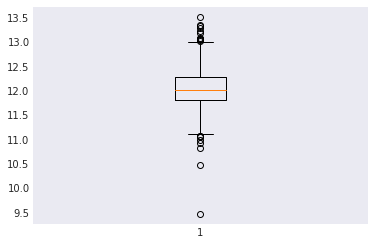

In [11]:
with plt.style.context('seaborn-dark'): 
    plt.boxplot(np.log(df['target']))
plt.show()

`-` 로그 변환을 해서 나온 이상치들을 제거하자

In [10]:
def remove_outlier(df):
    Q1 = np.log(df).quantile(0.25)
    Q3 = np.log(df).quantile(0.75)
    IQR = Q3 - Q1   

    filter_ = (np.log(df) >= Q1 - 1.5*IQR) & (np.log(df) <= Q3 + 1.5*IQR)
    return filter_

`-` df의 이상점을 제거한 df2를 만듦

In [47]:
df2 = df.copy()

In [44]:
df2['Overall_Qual'].unique()

array([10,  7,  5,  8,  6,  3,  4,  9,  2], dtype=int64)

`-` 위에서 제거한 이상점은 target의 이상점이다

`-` 그런데 위와 같이 이상점을 제거하면 target 전체를 기준으로 매우 큰 값 또는 작은 값만 제거된다

`-` 하지만 Overall Qual과 같은 변수로 target을 나눠서 보면 target 전체로 봤을 때의 이상점과 다르다

`-` 그렇기에 Overall Qual에 따른 target의 이상점을 제거하겠다

`-` 예컨대 Overall Qual이 3일 때 이상점으로 30만 달러의 집이 있다고 해도

`-` target 전체로 봤을 땐 이상점이 아니다

`-` 각각의 Overall_Qual에 대한 target의 이상점을 제거하자

`-` 각각의 Overall_Qual에 대한 target의 이상점을 제거할려고 했는데

`-` Overlall_Qual에 따라 모델을 만들것이 아니라서 전체 target의 이상점만 제거하기로 했다

In [30]:
# l = []
# for i in df2['Overall_Qual'].unique():
#     l.extend(remove_outlier(df2.query('Overall_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가
             
# l = list(set(l))

In [19]:
# l = []
# for i in df2['Kitchen_Qual'].unique():
#     l.extend(remove_outlier(df2.query('Kitchen_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가

# l = list(set(l))
# l = list(set(l) & set(remove_outlier(df2[['target']]).query('target == True').index.tolist()))

In [32]:
# df2 = df2.loc[l,:].reset_index().drop('index', axis = 1)

In [49]:
df2 = df2[remove_outlier(df2['target'])]

<AxesSubplot:>

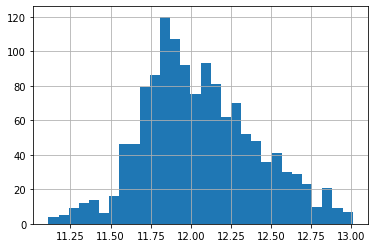

In [50]:
np.log(df2['target']).hist(bins = 30)

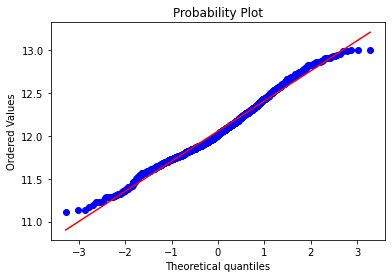

In [51]:
_ = stats.probplot(np.log(df2['target']), plot = plt)

In [52]:
test_stat, p_val = stats.shapiro(np.log(df2['target']))

In [53]:
p_val, np.log(df2['target']).skew() ## p값과 왜도

(2.6139335140840103e-09, 0.30128743590449364)

`-` 이상으로 이상점 제거를 끝냈다

In [73]:
dt = df2.copy()

In [74]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [75]:
dt['gap_year_now_bulit'] = 2022 - dt['Year_Built']

`-` train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 연도 변수로 위의 파생 변수를 사용하자

In [76]:
dt.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` 차고 면적은 차고 자리 개수와 관련이 있다

`-` 차고 자리 개수에 따라 차고 면적의 분포가 다름

`-` 그렇기에 원핫인코딩을 하고 둘을 곱한 파생 변수를 만들고 로그 변환을 해주자(오른쪽으로 꼬리가 긴 분포)

`-` 그런데 일단은 하지 말자

`-` 지상층 생활 면적과 1층 면적과 지하실 면적을 로그 변환하자(오른쪽으로 꼬리가 긴 분포)

In [77]:
dt['Gr_Liv_Area'] = np.log(dt['Gr_Liv_Area'])
dt['Garage_Area'] = np.log(dt['Garage_Area'])
dt['First_Flr_SF'] = np.log(dt['First_Flr_SF'])
dt['Total_Bsmt_SF'] = np.log(dt['Total_Bsmt_SF'])

In [79]:
dt.head() ## 로그 변환이 잘 되었다

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,10,7.779885,4,3,6.875232,4,7.779885,7.779885,4,2,19
1,7,7.209340,3,2,6.144186,3,7.209340,7.209340,4,2,16
2,5,6.802395,2,1,5.662960,2,6.761573,6.802395,2,1,55
3,5,7.068172,2,2,6.356108,3,6.522093,6.522093,2,1,122
4,7,7.579679,3,3,6.841615,3,6.933423,6.933423,3,2,17


## 모델링(부스팅)

`-` 여러가지 부스팅 모델을 사용해보자

### 스케일링

`-` z-점수 스케일링이나 로버스트 스케일링이나 비슷하다

`-` 계수를 통해 Overall_Qual과 Gr_Liv_Area이 매우 중요하며 그 다음은 Bsmt_Qual이다

`-` Kitchen_Qual과 Total_Bsmt_SF이 그 다음이며 나머지는 비슷하다

In [80]:
from sklearn.preprocessing import StandardScaler

In [81]:
## z-score 스케일러 생성
standard_scaler = StandardScaler()

## 스케일링
dt_scaled = standard_scaler.fit_transform(dt)
dt_scaled_df = pd.DataFrame(data = dt_scaled, columns = dt.columns)

In [82]:
dt_scaled_df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,2.955073,1.679132,2.822267,1.762432,1.909881,2.232825,2.375787,2.479985,2.041109,0.815269,-1.030914
1,0.626179,-0.197651,1.037875,0.213310,0.005244,0.693704,0.801414,0.644440,2.041109,0.815269,-1.134062
2,-0.926417,-1.536280,-0.746518,-1.335811,-1.248520,-0.845416,-0.434164,-0.664775,-0.875701,-1.021159,0.206866
3,-0.926417,-0.662018,-0.746518,0.213310,0.557376,0.693704,-1.094989,-1.566557,-0.875701,-1.021159,2.510511
4,0.626179,1.020562,1.037875,1.762432,1.822298,0.693704,0.040043,-0.243234,0.582704,0.815269,-1.099679


`-` 또한 Qual 관련 변수로 Overall Qual만 사용해봤는데 성능이 더 안좋게 나왔다(선형 회귀)

`-` 그래서 Qual 관련 변수를 추가했다

`-` 또한 현재 연도에서 완공 연도의 차이를 파생변수로 만들어 추가했다

`-` 사실 연도 변수는 포함시킬지 말지 고민했다

`-` 최근 연도일수록 집값이 평균적으로 높을텐데

`-` 이는 연도때문이라기 보다는 다른 변수에 의한 것이라 생각했기 때문이다

`-` 예컨대 과거에는 기술 등의 문제로 더 좋은 건물을 짓지 못했지만 최근에는 가능해진 상황

`-` 하지만 train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 포함하고 모델링 해보기로 했다

### 교차 검증

In [83]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer

In [84]:
x_train, x_valid, y_train, y_valid = train_test_split(dt_scaled_df, target, shuffle = True, test_size = 0.2, random_state = 22)

In [85]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [86]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [87]:
def my_custom_loss_func(true, pred):
    return NMAE(np.exp(true), np.exp(pred)) ## 로그 변환을 위한 손실 함수

In [88]:
score = make_scorer(my_custom_loss_func, greater_is_better = False) ## 작을수록 좋다 

In [126]:
params = {'learning_rate':0.03,
          'max_depth':3,
          'n_estimators':500,
          'metric':'mae',
          'seed':22}

In [149]:
gb = GradientBoostingRegressor(random_state = 22, n_estimators = 500, learning_rate = 0.03, max_depth = 3)
cb = CatBoostRegressor(random_state = 222, learning_rate = 0.03, n_estimators = 500, depth = 3, loss_function = 'MAE', verbose = 0)
xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 3, learning_rate = 0.03) 
lgb = LGBMRegressor(random_state = 22, n_estimators = 500, max_depth = 3, learning_rate = 0.03)

In [131]:
for model in [gb, cb, xgb, lgb]:
    scores = cross_validate(model, x_train, log_y_train, scoring = score, cv = 10)
    model.fit(x_train, log_y_train)
    print('---------------------------------------------')
    print('교차 검증별 NMAE: ', -scores['test_score'])
    print('평균 교차 검증 NMAE: ', np.mean(-scores['test_score']))
    print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(model.predict(x_valid))))

---------------------------------------------
교차 검증별 NMAE:  [0.09825523 0.11957861 0.09228815 0.1009453  0.08686296 0.08607822
 0.09723404 0.08882254 0.09167116 0.07969104]
평균 교차 검증 NMAE:  0.09414272571258657
valid에 대한 검증 NMAE:  0.09327363829345853
---------------------------------------------
교차 검증별 NMAE:  [0.09168768 0.11198073 0.09045588 0.10705738 0.08097689 0.07740045
 0.10341037 0.0884669  0.0949103  0.07875323]
평균 교차 검증 NMAE:  0.09250998090891124
valid에 대한 검증 NMAE:  0.09537103423527143
---------------------------------------------
교차 검증별 NMAE:  [0.09469139 0.11876199 0.09434135 0.1018124  0.08281141 0.08264961
 0.09394308 0.09010295 0.09143423 0.08040145]
평균 교차 검증 NMAE:  0.09309498670321215
valid에 대한 검증 NMAE:  0.09646062690079403
---------------------------------------------
교차 검증별 NMAE:  [0.09354834 0.11601373 0.08962922 0.0981409  0.08753513 0.08450661
 0.09786521 0.08918322 0.09336603 0.07587111]
평균 교차 검증 NMAE:  0.09256595140948579
valid에 대한 검증 NMAE:  0.0951102884570039


`-` 아래는 예전에 했던 방식

In [ ]:
for model in [rf, gb, ad, xgb, lgb]:
    scores = cross_validate(model, x_train, log_y_train, scoring = score, cv = 10)
    model.fit(x_train, log_y_train)
    print('---------------------------------------------')
    print('교차 검증별 NMAE: ', -scores['test_score'])
    print('평균 교차 검증 NMAE: ', np.mean(-scores['test_score']))
    print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(model.predict(x_valid))))

---------------------------------------------
교차 검증별 NMAE:  [0.09069717 0.09542324 0.09053177 0.09930363 0.09879612 0.09823109
 0.09031211 0.0844011  0.1003161  0.08260519]
평균 교차 검증 NMAE:  0.09306175212129086
valid에 대한 검증 NMAE:  0.08757140289281869
---------------------------------------------
교차 검증별 NMAE:  [0.09450406 0.09229055 0.08658855 0.09936189 0.10160993 0.10323769
 0.09040929 0.08530859 0.10261107 0.0872947 ]
평균 교차 검증 NMAE:  0.09432163140518088
valid에 대한 검증 NMAE:  0.08502093478974589
---------------------------------------------
교차 검증별 NMAE:  [0.10474376 0.1044917  0.108671   0.11292011 0.10662772 0.11692226
 0.1044543  0.09510495 0.11135832 0.09690058]
평균 교차 검증 NMAE:  0.10621946953437231
valid에 대한 검증 NMAE:  0.10984493084650232
---------------------------------------------
교차 검증별 NMAE:  [0.10479987 0.09271494 0.0867327  0.10170367 0.09710625 0.09705917
 0.09448252 0.08727167 0.1011098  0.08602371]
평균 교차 검증 NMAE:  0.09490042984584213
valid에 대한 검증 NMAE:  0.084614942415492
------

`-` Adaboost를 제외하면 성능이 괜찮다

### 앙상블

`-` 위에서 만든 모델을 섞어 test 데이터를 예측하자

In [138]:
test['gap_year_now_bulit'] = 2022 - test['Year_Built']

`-` train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 연도 변수로 위의 파생 변수를 사용하자

In [139]:
test.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` 차고 면적은 차고 자리 개수와 관련이 있다

`-` 차고 자리 개수에 따라 차고 면적의 분포가 다름

`-` 그렇기에 원핫인코딩을 하고 둘을 곱한 파생 변수를 만들고 로그 변환을 해주자(오른쪽으로 꼬리가 긴 분포)

`-` 그런데 일단은 하지 말자(하지 말고 그냥 드랍하자)

`-` 지상층 생활 면적과 1층 면적과 지하실 면적과 연도를 로그 변환하자(오른쪽으로 꼬리가 긴 분포)

In [140]:
test['Gr_Liv_Area'] = np.log(test['Gr_Liv_Area'])
test['Garage_Area'] = np.log(test['Garage_Area'])
test['First_Flr_SF'] = np.log(test['First_Flr_SF'])
test['Total_Bsmt_SF'] = np.log(test['Total_Bsmt_SF'])

In [141]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

In [142]:
test_scaled = standard_scaler.transform(test)
test_scaled_df = pd.DataFrame(data = test_scaled, columns = test.columns)

In [144]:
test_scaled_df.head() ## 로그 변환이 잘 되었다

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,2.178775,0.743798,1.037875,0.213310,1.072783,2.232825,1.591165,1.565202,2.041109,0.815269,-1.168445
1,-0.150119,-0.930456,-0.746518,-1.335811,-1.723533,-0.845416,0.186688,-0.072262,-0.875701,-1.021159,0.860138
2,-0.150119,0.300372,1.037875,0.213310,-0.144332,0.693704,-0.802633,-1.170850,0.582704,0.815269,-0.927765
3,-0.150119,1.748530,1.037875,1.762432,1.224174,0.693704,0.374006,0.146130,0.582704,0.815269,-1.065296
4,-0.926417,-1.060687,-0.746518,0.213310,1.012715,-0.845416,0.077441,-0.199632,-0.875701,-1.021159,0.172483


In [145]:
kfold = KFold(n_splits = 10, random_state = 22, shuffle = True)

In [148]:
log_target = np.log(target)

`-` cat 부스트

In [151]:
cb_valid = []
cb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    cb = CatBoostRegressor(random_state = 222, learning_rate = 0.03, n_estimators = 500, depth = 3, loss_function = 'MAE', verbose = 0)
    cb.fit(x_train, y_train)
    y_predict = np.exp(cb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(cb.predict(test_scaled_df)) ## test셋 예측

    cb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    cb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 그래디언트 부스트

In [152]:
gb_valid = []
gb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    gb = GradientBoostingRegressor(random_state = 22, n_estimators = 500, learning_rate = 0.03, max_depth = 3) 
    gb.fit(x_train, y_train)
    y_predict = np.exp(gb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(gb.predict(test_scaled_df)) ## test셋 예측

    gb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    gb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` xgb

In [153]:
xgb_valid = []
xgb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    xgb = XGBRegressor(random_state = 22, n_estimators = 500, learning_rate = 0.03, max_depth = 3) 
    xgb.fit(x_train, y_train)
    y_predict = np.exp(xgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(xgb.predict(test_scaled_df)) ## test셋 예측

    xgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    xgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` lgbm

In [154]:
lgb_valid = []
lgb_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    lgb = LGBMRegressor(random_state = 22, n_estimators = 700, max_depth = 3, learning_rate = 0.03)
    lgb.fit(x_train, y_train)
    y_predict = np.exp(lgb.predict(x_valid)) ## valid셋 예측
    test_predict = np.exp(lgb.predict(test_scaled_df)) ## test셋 예측

    lgb_valid.append(NMAE(y_predict, y_valid)) ## valid 예측값
    lgb_predict += test_predict / 10 ## test 예측값(10 Fold)

`-` 4개의 모형을 앙상블하자

In [271]:
pred = (rf_predict + gb_predict + xgb_predict + lgb_predict) * 0.25 ## 예전 방식
# pred = (gb_predict + xgb_predict + lgb_predict) / 3 ---> 이게 점수 더 잘나옴(랜덤 포레스트가 별로인 듯)
# 점수는 0.10217이다

In [166]:
pred = (cb_predict + gb_predict + xgb_predict + lgb_predict) / 4

In [159]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

In [167]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,338903.325696
1,2,132275.668027
2,3,175242.763379
3,4,246726.603024
4,5,134197.295835


In [165]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission9.csv', index = False)

## 이상점 제거 X

`-` 이상점을 제거하지 않아봄(트리 기반 모델은 이상점에 덜 민감함)

In [201]:
dt = df.copy()

`-` 다음 컬럼들은 변수 값별 target의 중위값으로 인코딩

In [227]:
cols = ['Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual']

In [218]:
for c in cols :
    ord_df = dt.groupby(c).target.median().reset_index(name = f'ord_{c}')
    dt = pd.merge(dt, ord_df, how = 'left')
    test = pd.merge(test, ord_df, how = 'left')

In [221]:
dt.drop(cols, axis = 1, inplace = True)
test.drop(cols, axis = 1, inplace = True)

`-` 타겟 인코딩을 하면서 test 데이터에 결측값(1개)이 발생

In [234]:
test[test.ord_Kitchen_Qual.isnull()]

,Overall_Qual,Gr_Liv_Area,Garage_Cars,Garage_Area,Total_Bsmt_SF,First_Flr_SF,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,ord_Exter_Qual,ord_Kitchen_Qual,ord_Bsmt_Qual
878,5,1224,1,180,689,725,1,1917,1950,1917,142312.5,NaN,193000.0


`-` dt의 중앙값으로 대체함

In [235]:
test.fillna(dt.ord_Kitchen_Qual.median(), inplace = True)

`-` 연도 피쳐는 드랍(의미 없어 보인다)

In [239]:
dt.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)
test.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

In [241]:
target = dt['target']  ## target
dt.drop('target', axis = 1, inplace = True)   ## target 제외한 데이터프레임

### 모델링

`-` 일단은 스케일링 하지 않음

In [238]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer

In [242]:
x_train, x_valid, y_train, y_valid = train_test_split(dt, target, shuffle = True, test_size = 0.2, random_state = 22)

In [243]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [244]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [245]:
def my_custom_loss_func(true, pred):
    return NMAE(np.exp(true), np.exp(pred)) ## 로그 변환을 위한 손실 함수

In [246]:
score = make_scorer(my_custom_loss_func, greater_is_better = False) ## 작을수록 좋다 

In [254]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')

In [252]:
log_target = np.log(target)

In [255]:
scores = cross_validate(rf, dt, log_target, scoring = score, cv = 10)
rf.fit(x_train, log_y_train)
print('-----------------랜덤포레스트---------------------')
print('교차 검증별 NMAE: ', abs(scores['test_score']))
print('평균 교차 검증 NMAE: ', np.mean(abs(scores['test_score'])))
print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(rf.predict(x_valid))))

-----------------랜덤포레스트---------------------
교차 검증별 NMAE:  [0.09774087 0.10535609 0.11505462 0.10144409 0.10108346 0.09631843
 0.11027896 0.10163337 0.11041766 0.0997512 ]
평균 교차 검증 NMAE:  0.10390787474990973
valid에 대한 검증 NMAE:  0.106494377303765


In [259]:
rf.fit(dt, target)

RandomForestRegressor(criterion='mae', random_state=22)

In [262]:
dict(zip(rf.feature_names_in_, rf.feature_importances_))

{'Overall_Qual': 0.37293462948796124,
 'Gr_Liv_Area': 0.16089608391551238,
 'Garage_Cars': 0.014278231901710847,
 'Garage_Area': 0.12494360623796022,
 'Total_Bsmt_SF': 0.10065061657514864,
 'First_Flr_SF': 0.0935867623506591,
 'Full_Bath': 0.06402602105445104,
 'ord_Exter_Qual': 0.012468516017666686,
 'ord_Kitchen_Qual': 0.019439162543942744,
 'ord_Bsmt_Qual': 0.036776369914987075}

In [284]:
_ = pd.DataFrame(dict(zip(rf.feature_names_in_, rf.feature_importances_)), index = [0]).T.\
reset_index().rename(columns = {'index':'feature', 0:'importance'}).\
sort_values('importance', ascending = False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

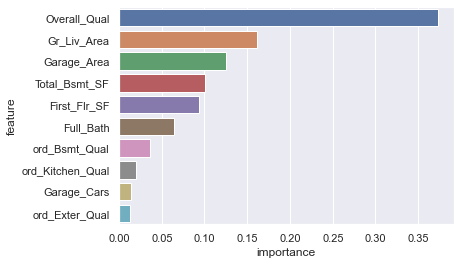

In [285]:
sns.barplot(y = 'feature', x = 'importance', data = _)

`-` 이상점 제거 안하고 딱히 전처리 안했을 때 랜덤포레스트의 성능과 피쳐의 중요도는 위와 같다